<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/experimental/signal_kalman_banknifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [33]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
pd.options.mode.chained_assignment = None

In [35]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftyfmcglist.csv')

In [36]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [37]:
#nifty=yf.download('^nsebank',start=START)

In [38]:
lst=[]
stocklst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  stocklst.append(df['Adj Close'])
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [118]:
weight_matrix=[0.2711, 0.2477, 0.860,0.643,0.575,0.480,0.453,0.390,0.374,0.273]
stocklst=[item*weight for item in stocklst for weight in  weight_matrix]

In [119]:
nifty=pd.DataFrame(stocklst).T.sum(axis=1)

In [120]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [121]:
df_kalman = pd.DataFrame(nlst).T

In [122]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [123]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [124]:
final_kalman=macd_calc(df_kalman)

In [125]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,kalman_13,kalman_14,kalman_15,macdkalman_1,macdsignalkalman_1,histkalman_1,macdkalman_2,macdsignalkalman_2,histkalman_2,macdkalman_3,macdsignalkalman_3,histkalman_3,macdkalman_4,macdsignalkalman_4,histkalman_4,macdkalman_5,macdsignalkalman_5,histkalman_5,macdkalman_6,macdsignalkalman_6,histkalman_6,macdkalman_7,macdsignalkalman_7,histkalman_7,macdkalman_8,macdsignalkalman_8,histkalman_8,macdkalman_9,macdsignalkalman_9,histkalman_9,macdkalman_10,macdsignalkalman_10,histkalman_10,macdkalman_11,macdsignalkalman_11,histkalman_11,macdkalman_12,macdsignalkalman_12,histkalman_12,macdkalman_13,macdsignalkalman_13,histkalman_13,macdkalman_14,macdsignalkalman_14,histkalman_14,macdkalman_15,macdsignalkalman_15,histkalman_15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-17,-44.837299,-109.151625,34.878684,7.078007,14.338832,-38.495618,25.515370,51.988843,1327.049618,2051.158947,325.519905,101.809445,227.367973,215.579232,162.613992,-65.100472,-44.178736,-20.921736,-41.183839,-34.774376,-6.409464,-7.357212,-6.969715,-0.387497,-13.543861,-13.533060,-0.010801,-35.551702,-26.753173,-8.798529,-66.275060,-47.531014,-18.744046,0.457192,1.946123,-1.488931,-6.454989,-3.475938,-2.979051,-142.094807,-124.379242,-17.715565,166.749831,98.231225,68.518606,17.478154,21.693036,-4.214882,-11.054942,-11.532895,0.477953,12.482155,17.175764,-4.693609,28.914882,30.594398,-1.679516,0.348008,-1.570691,1.918699
2021-11-18,-84.339771,-113.411846,32.551537,4.532455,17.265289,-46.577315,23.132888,38.006894,1277.708488,2175.445835,343.170969,91.440444,198.077223,202.246640,160.253425,-68.383325,-46.726587,-21.656738,-42.117852,-35.547373,-6.570479,-7.130070,-6.986594,-0.143476,-13.966023,-13.578635,-0.387389,-36.183342,-27.745822,-8.437520,-66.832394,-49.562739,-17.269655,0.465993,1.790320,-1.324327,-7.256001,-3.873840,-3.382161,-131.994881,-125.180889,-6.813992,182.267307,107.077128,75.190179,17.756438,21.278658,-3.522219,-11.294152,-11.507764,0.213612,9.018110,16.317064,-7.298954,26.847667,30.200005,-3.352338,0.259522,-1.378037,1.637559


In [126]:
features = final_kalman.columns.tolist()

In [127]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [128]:
final_dataframe=final_kalman[feats_set1]

In [129]:
solution=np.sign(final_dataframe)

In [130]:
solution['final']=solution.sum(axis=1)

In [131]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,histkalman_11,histkalman_12,histkalman_13,histkalman_14,histkalman_15,final
Date,,,,,,,,,,,,,,,,
2021-11-17,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-9.0
2021-11-18,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-9.0


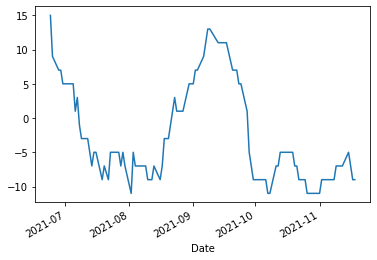

In [132]:
solution.final[-100:].plot()

In [133]:
l=700

In [134]:
nifty=nifty[-l:]
solution=solution[-l:]

In [135]:
nifty.tail(5)

Date
2021-11-12    2.111658e+07
2021-11-15    2.137674e+07
2021-11-16    2.130833e+07
2021-11-17    2.122796e+07
2021-11-18    2.123239e+07
dtype: float64

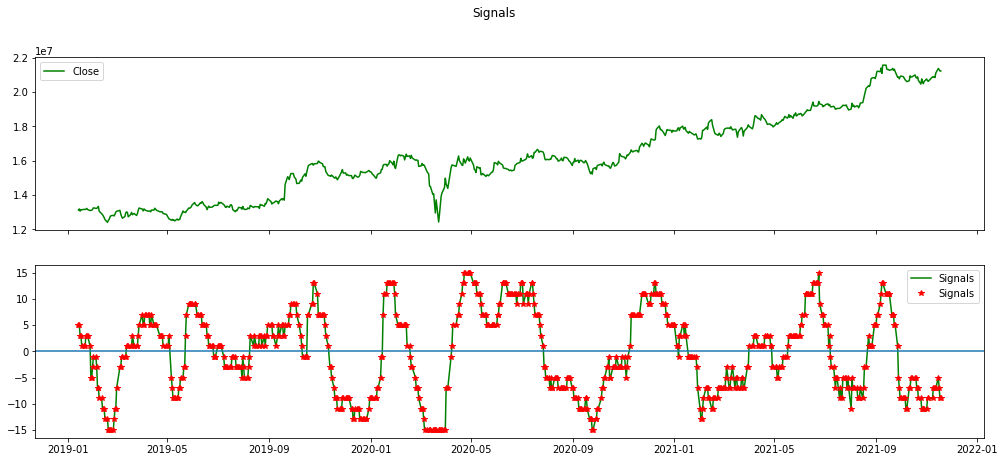

In [136]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty,'g', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'g', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [137]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [138]:
solution.final.tail(1)

Date
2021-11-18   -9.0
Name: final, dtype: float64

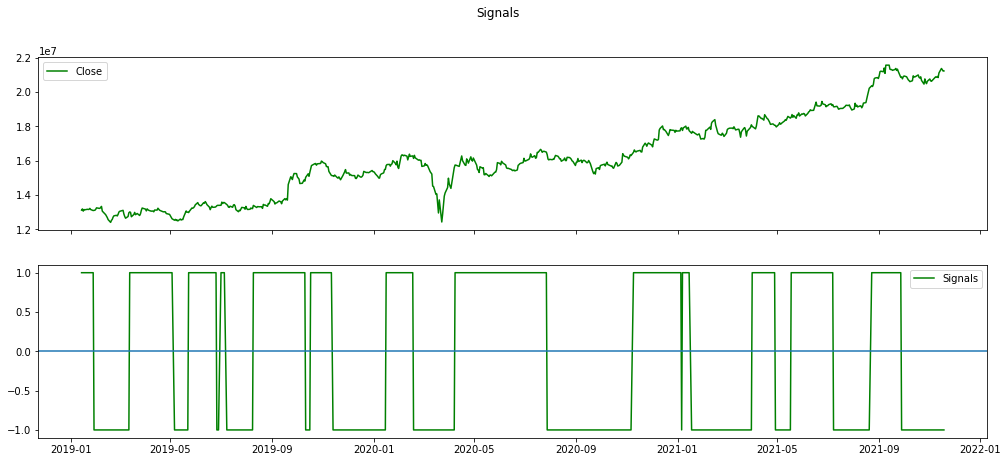

In [139]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty,'g', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'signals'],'g', label='Signals')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [140]:
solution[['signals']].to_csv('kalman_k.csv')

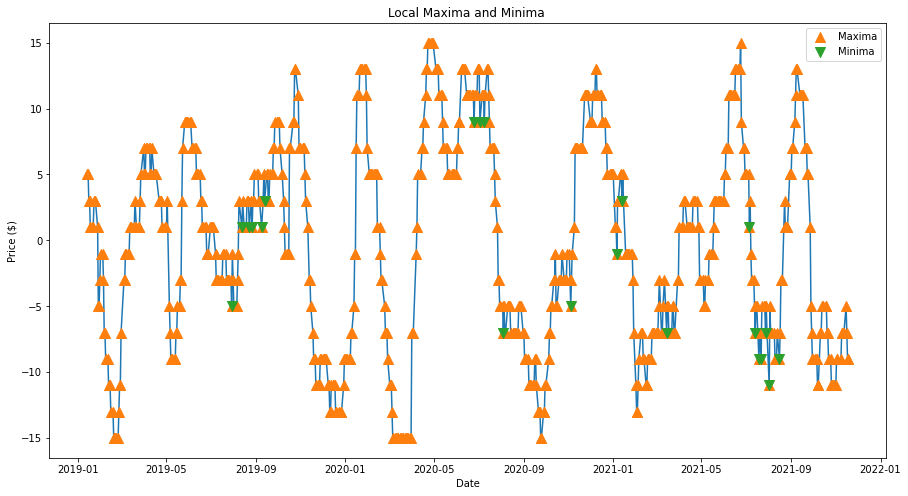

In [141]:
solution['local_max'] = solution['final'][
  (solution['final'].shift(1) < solution['final']) &
  (solution['final'].shift(-1) < solution['final'])]
solution['local_min'] = solution['final'][
  (solution['final'].shift(1) > solution['final']) &
  (solution['final'].shift(-1) > solution['final'])]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 8))
plt.plot(solution['final'], zorder=0)
plt.scatter(solution.index, solution['final'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(solution.index, solution['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima ')
plt.legend()
plt.show()

In [142]:
from scipy.signal import argrelextrema

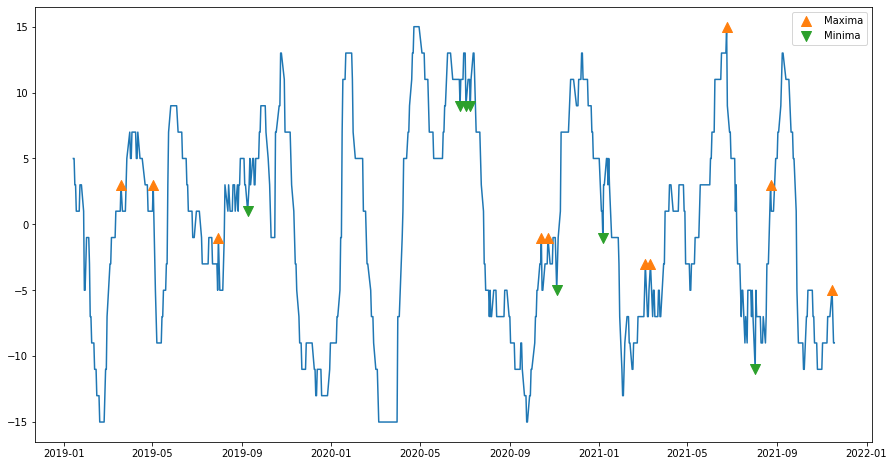

In [143]:
max_idx = argrelextrema(solution['final'].values, 
  np.greater, order=3)[0]
min_idx = argrelextrema(solution['final'].values, 
  np.less, order=3)[0]
plt.figure(figsize=(15, 8))
plt.plot(solution['final'], zorder=0)
plt.scatter(solution.iloc[max_idx].index, solution.iloc[max_idx]['final'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(solution.iloc[min_idx].index, solution.iloc[min_idx]['final'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.legend()
plt.show()